<a href="https://colab.research.google.com/github/KenObata/Music4All_personal_project/blob/main/week14_SMOTE%2BEDA(partial_fit%2Calpha%3D0_1)_on_TF_IDF_MNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week14: This notebook is to apply Easy Data Augmentation -> then SMOTE to balance genres using TF-IDF.

Situation: English only (=multi-class).
Split: StratifiedKfold.
Reference: https://github.com/jasonwei20/eda_nlp


### Preprocess: import files

In [1]:
#Check RAM size. If small, you can upgrade.
#you can enable a high-RAM runtime via Runtime > Change runtime type in the menu
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
plt.style.use('seaborn')

CSV_FOLDER = 'drive/MyDrive/music4all/'
LANG_DIR = 'drive/MyDrive/music4all/split-language_only-artist_grouped'
SPLIT_DIR = 'drive/MyDrive/music4all/split-all_labels'
FIG_DIR = 'drive/MyDrive/music4all/figures'

font = {'size': 22}

matplotlib.rc('font', **font)

scikit-multilearn has to be installed from pip
https://github.com/scikit-multilearn/scikit-multilearn/issues/142

In [4]:
def write_txt(path, list_of_str):
    with open(path, 'w') as f:
        for value in list_of_str:
            f.write(value)
            f.write('\n')

In [5]:
def analyze_genre_tag_df(df, target_column:int, top_n=100):
    """plot the occurrences of top_n items in the given df"""
    def get_counter(items: list):
        """items: list of list"""    
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        items = Counter(items)    
        return items
    
    def plot_freqs(counter: Counter, top_n, title=''):
        most_common = counter.most_common(top_n)
        names, counts = list(zip(*most_common))

        xs = np.arange(len(names))
        plt.figure(figsize=(18, 7))
        plt.bar(xs, counts)
        plt.xticks(xs + 0.2, names, rotation=60, size=17, ha='right') 
        plt.title('Top-%d %s (out of %d in total)' % (top_n, title, len(counter)), size=20)
        plt.ylabel('occurrence', size=17)
        
    column_name = df.columns[target_column]
    labels = df[column_name].tolist()
    labels = get_counter(labels)
    
    print('Number of %s: %d' % (column_name, len(labels)))

    plot_freqs(labels, top_n=top_n, title=column_name)
    return labels
    
def analyze_genre_tag_csv(csv_path, top_n):
    """wrapper of analyze_genre_tag_df"""
    basename = os.path.basename(csv_path)
    df = pd.read_csv(os.path.join(CSV_FOLDER, csv_path), header=0, sep='	')
    df.head()
    return analyze_genre_tag_df(df, target_column=1,top_n=top_n)

### Data preparation

id_genres.csv

Number of genres: 853


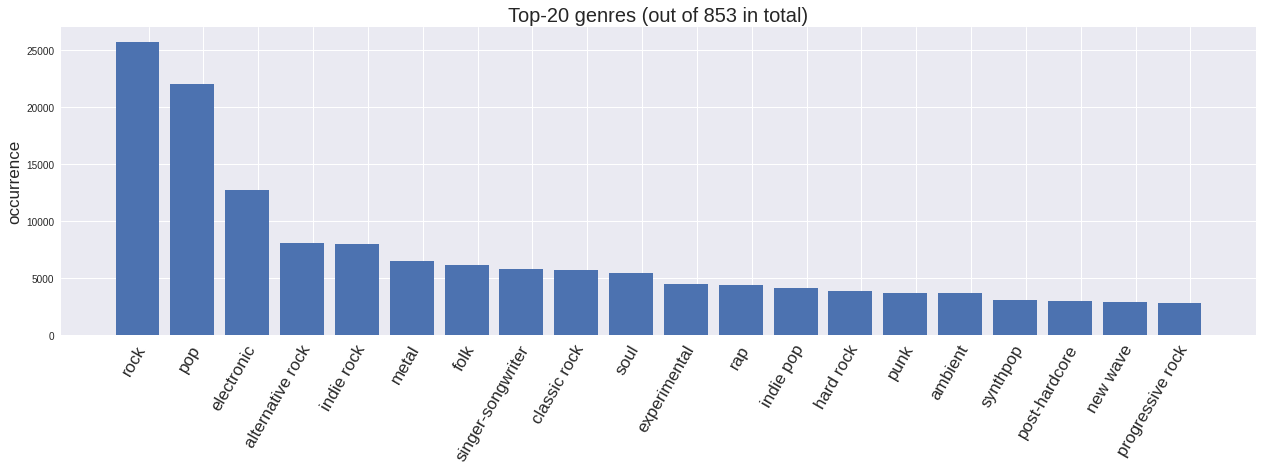

In [6]:
genre_counter = analyze_genre_tag_csv('id_genres.csv', top_n=20)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-genre.png'))

In [7]:
genre_counter = sorted(genre_counter.items(), key=lambda item: item[1], reverse = True)
genre_counter_top = genre_counter[:15]

In [8]:
genre_counter_top_list = [genre for genre, count in genre_counter_top ]
genre_counter_top_list

['rock',
 'pop',
 'electronic',
 'alternative rock',
 'indie rock',
 'metal',
 'folk',
 'singer-songwriter',
 'classic rock',
 'soul',
 'experimental',
 'rap',
 'indie pop',
 'hard rock',
 'punk']

In [9]:
#filter genre dataset as top15 genre only and later inner join with English.
df_genres = pd.read_csv(os.path.join(CSV_FOLDER, 'id_genres.csv'), header=0, sep='	')
df_genre_top20 = df_genres[df_genres['genres'].isin(genre_counter_top_list)]
df_genre_top20

,id,genres
0,0009fFIM1eYThaPg,pop
11,00P2bHdWFkghmDqz,soul
14,00XWljDxNBgBKEEA,pop
16,00b6fV3nx5z2b8Ls,pop
26,013QDoTqbexEwkHr,pop
...,...,...
109253,zzgS4ZqyswamEWNj,pop
109254,zziALZG1JQ2uUjcy,metal
109262,zzx8CWdM7qkxKQpC,indie rock
109265,zzz0n04uuTUA7fNh,pop


Dataframe narrowed down to 18603 rows. Notice that rank20 has only 169 data. So depending on the result we might need to narrow down to top10 genre?

### Filter only English
 Note that this split have overlapping artist in both sets. See artist-grouped-stratified-split for an improved version.

In [10]:
en_lang =['en']
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')
df_lang_en=df_lang[ df_lang['lang'].isin(en_lang) ]
df_lang_en

,id,lang
0,0009fFIM1eYThaPg,en
1,0010xmHR6UICBOYT,en
2,002Jyd0vN4HyCpqL,en
3,006TYKNjNxWjfKjy,en
4,007LIJOPQ4Sb98qV,en
...,...,...
109264,zzyyPUs7hC9Nz2e1,en
109265,zzz0n04uuTUA7fNh,en
109266,zzzj3LYaZtYtbzSr,en
109267,zzznMjZAKnJJXQSj,en


Originally it was 109269 rows, and now there are 84103 rows.

### Now, combine split by language and genre, so we classify each genre by language.

In [11]:
# merge three dataframes into one
df_genre_by_lang = pd.concat([df_genre_top20['id'], df_genre_top20['genres'], df_lang_en['lang']]
                             , join='inner' ,axis=1)

#Do inner join
df_genre_by_lang


,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
11,00P2bHdWFkghmDqz,soul,en
16,00b6fV3nx5z2b8Ls,pop,en
26,013QDoTqbexEwkHr,pop,en
30,01EKNot8qVgZpKM7,rock,en
...,...,...,...
109253,zzgS4ZqyswamEWNj,pop,en
109254,zziALZG1JQ2uUjcy,metal,en
109262,zzx8CWdM7qkxKQpC,indie rock,en
109265,zzz0n04uuTUA7fNh,pop,en


ToDo: concatenate to the dataframe!

In [12]:
final_genre_list = ["pop", "rock", "soul", "indie rock", "rap", "electronic", "folk", "singer-songwriter", "indie pop", "punk"]
#df_lang_en=df_lang[ df_lang['lang'].isin(en_lang) ]
df_genre_by_lang = df_genre_by_lang[ df_genre_by_lang["genres"].isin(final_genre_list) ]

After inner join, we can drop the bottom 5, alternative rock, hard rock, experimental, classic rock, and metal

Reindex

In [13]:
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)
df_genre_by_lang

,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
1,00P2bHdWFkghmDqz,soul,en
2,00b6fV3nx5z2b8Ls,pop,en
3,013QDoTqbexEwkHr,pop,en
4,01EKNot8qVgZpKM7,rock,en
...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en
13536,zzgS4ZqyswamEWNj,pop,en
13537,zzx8CWdM7qkxKQpC,indie rock,en
13538,zzz0n04uuTUA7fNh,pop,en


### Get lyrics document as dataframe and append to X_train, X_test

In [14]:
#create lyric column
df_genre_by_lang["lyric"] = ""
df_genre_by_lang

,id,genres,lang,lyric
0,0009fFIM1eYThaPg,pop,en,
1,00P2bHdWFkghmDqz,soul,en,
2,00b6fV3nx5z2b8Ls,pop,en,
3,013QDoTqbexEwkHr,pop,en,
4,01EKNot8qVgZpKM7,rock,en,
...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,
13536,zzgS4ZqyswamEWNj,pop,en,
13537,zzx8CWdM7qkxKQpC,indie rock,en,
13538,zzz0n04uuTUA7fNh,pop,en,


In [15]:
#create temporary lyric folder on google collab
# do not read texts from google drive. it is slow.
ZIP_FILE ="drive/MyDrive/music4all/lyrics.zip"

!unzip drive/MyDrive/music4all/lyrics.zip -d /content/

Archive:  drive/MyDrive/music4all/lyrics.zip
replace /content/lyrics/0009fFIM1eYThaPg.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### This time, apply stemming and normilize words

In [16]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [17]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
stemmer = PorterStemmer()

In [18]:
text = "This is a test sentence. Yo, 123 today2022"
text= text.replace(',', '')
text = text.replace('.', '').lower() 
text_tokens = [word for word in text.split(' ') ]
print(text_tokens)

#text_tokens_alphabet = []
#for word in text.split(' '):
#  temp_word = stemmer.stem(word)
#  print("temp:", temp_word)
#  if temp_word.isalpha():
#    text_tokens_alphabet.append(temp_word)
text_tokens_alphabet = [word for word in text.split(' ') if wordnet.synsets(word)]
print(text_tokens_alphabet)

['this', 'is', 'a', 'test', 'sentence', 'yo', '123', 'today2022']
['is', 'a', 'test', 'sentence']


This study removes "," and "." to get only alphabets.

In [19]:
from nltk.corpus import wordnet
#First 5000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

df_genre_by_lang['number_of_line'] = 0
#df_genre_by_lang['text_split'] = []
for idx, row in df_genre_by_lang.loc[0:5000].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read()
      number_of_line = lyric_document.count('\n')

      lyric_document = lyric_document.replace('\n', ' ').replace(',', '').replace('.', '')
      lyric_document.lower()
      #text_split = [stemmer.stem(word) for word in lyric_document.split(' ') if word.isalpha() ]
      text_split = [word for word in lyric_document.split(' ') if wordnet.synsets(word) ]
      lyric_document=[' '.join(text_split) ]
      
      #df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "text_split"] =text_split
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "number_of_line"] = number_of_line
      #print(lyric_document)

  except Exception as e:
    print(e)


In [20]:
from nltk.corpus import wordnet
#First 5000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

df_genre_by_lang['number_of_line'] = 0
#df_genre_by_lang['text_split'] = []
for idx, row in df_genre_by_lang.loc[5001:df_genre_by_lang.shape[0]].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read()
      number_of_line = lyric_document.count('\n')

      lyric_document = lyric_document.replace('\n', ' ').replace(',', '').replace('.', '')
      lyric_document.lower()
      #text_split = [stemmer.stem(word) for word in lyric_document.split(' ') if word.isalpha() ]
      text_split = [word for word in lyric_document.split(' ') if wordnet.synsets(word) ]
      lyric_document=[' '.join(text_split) ]
      
      #df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "text_split"] =text_split
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "number_of_line"] = number_of_line
      #print(lyric_document)

  except Exception as e:
    print(e)

In [21]:
#Reindex again
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)

In [22]:
df_genre_by_lang[0:df_genre_by_lang.shape[0]]

,id,genres,lang,lyric,number_of_line
0,0009fFIM1eYThaPg,pop,en,a sunny day so I got nowhere hide Not a cloud ...,0
1,00P2bHdWFkghmDqz,soul,en,Tell me a tale always was Sing me a song alway...,0
2,00b6fV3nx5z2b8Ls,pop,en,A A went school learn girl Things never never ...,0
3,013QDoTqbexEwkHr,pop,en,like a conversation stops breathe Is it imagin...,0
4,01EKNot8qVgZpKM7,rock,en,Say words I say Say on another day Fragile wor...,0
...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think afraid come in know been made up Hold ti...,18
13536,zzgS4ZqyswamEWNj,pop,en,Oh yeah yeah Last night I took a walk in snow ...,75
13537,zzx8CWdM7qkxKQpC,indie rock,en,Innocence it come easy in a sense it never wil...,34
13538,zzz0n04uuTUA7fNh,pop,en,Girl know I feel I really been away oh baby An...,65


In [23]:
df_genre_by_lang.shape[0]

13540

### Apply Data Augmentation Preprocess

In [24]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [26]:
# Easy data augmentation techniques for text classification
# Jason Wei and Kai Zou

import random
from random import shuffle
random.seed(1)

#stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

#cleaning up text
import re
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################

#for the first time you use wordnet
#import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet 

def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################

def random_deletion(words, p):

	#obviously, if there's only one word, don't delete it
	if len(words) == 1:
		return words

	#randomly delete words with probability p
	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	#if you end up deleting all words, just return a random word
	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################

def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)
	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0
	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words
	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################

def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		random_word = new_words[random.randint(0, len(new_words)-1)]
		synonyms = get_synonyms(random_word)
		counter += 1
		if counter >= 10:
			return
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

########################################################################
# main data augmentation function
########################################################################

def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
	
	sentence = get_only_chars(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not '']
	num_words = len(words)
	
	augmented_sentences = []
	num_new_per_technique = int(num_aug/4)+1

	#sr
	if (alpha_sr > 0):
		n_sr = max(1, int(alpha_sr*num_words))
		for _ in range(num_new_per_technique):
			a_words = synonym_replacement(words, n_sr)
			augmented_sentences.append(' '.join(a_words))

	#ri
	if (alpha_ri > 0):
		n_ri = max(1, int(alpha_ri*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_insertion(words, n_ri)
			augmented_sentences.append(' '.join(a_words))

	#rs
	if (alpha_rs > 0):
		n_rs = max(1, int(alpha_rs*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_swap(words, n_rs)
			augmented_sentences.append(' '.join(a_words))

	#rd
	if (p_rd > 0):
		for _ in range(num_new_per_technique):
			a_words = random_deletion(words, p_rd)
			augmented_sentences.append(' '.join(a_words))

	augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
	shuffle(augmented_sentences)

	#trim so that we have the desired number of augmented sentences
	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	#append the original sentence
	augmented_sentences.append(sentence)

	return augmented_sentences

### Data Preparation(Kfold split)

Create dataframe for Gensim

In [64]:
def load_data(df_col, y):
    texts, labels = [], []
    
    for line in df_col:
        # texts are already tokenized, just split on space
        # in a real use-case we would put more effort in preprocessing
        texts.append(line.split(' '))
    return pd.DataFrame({'texts': texts, 'labels': y})

In [65]:
data = load_data(df_genre_by_lang["lyric"], df_genre_by_lang["genres"])

In [66]:
data

,texts,labels
0,"[a, sunny, day, so, I, got, nowhere, hide, Not...",pop
1,"[Tell, me, a, tale, always, was, Sing, me, a, ...",soul
2,"[A, A, went, school, learn, girl, Things, neve...",pop
3,"[like, a, conversation, stops, breathe, Is, it...",pop
4,"[Say, words, I, say, Say, on, another, day, Fr...",rock
...,...,...
13535,"[think, afraid, come, in, know, been, made, up...",indie rock
13536,"[Oh, yeah, yeah, Last, night, I, took, a, walk...",pop
13537,"[Innocence, it, come, easy, in, a, sense, it, ...",indie rock
13538,"[Girl, know, I, feel, I, really, been, away, o...",pop


In [67]:
data['labels'] = data['labels'].astype('category')
label_mapping = data['labels'].cat.categories
data['labels'] = data['labels'].cat.codes
X = data['texts']
y = data['labels']

In [68]:
type(X)

pandas.core.series.Series

In [69]:
def StratifiedKFold_feature_and_df_glove(df, feature_list, y_name):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  y = df[y_name]
  skf.get_n_splits(df[ feature_list ], y)

  splits = []

  for train_index, test_index in skf.split(df[ feature_list ], y):
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = df[ feature_list ].loc[train_index], df[ feature_list ].loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [70]:
def StratifiedKFold_feature_and_df(X, y):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  #y = df[y_name]
  skf.get_n_splits(X, y)#df[ feature_list ]

  splits = []

  for train_index, test_index in skf.split(X, y):#df[ feature_list ]
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X.loc[train_index], X.loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [71]:
#feature_list = ["texts"] #this is BOW and TF-IDF
#splits = StratifiedKFold_feature_and_df( data, feature_list, 'labels')
splits = StratifiedKFold_feature_and_df( X,y)

TRAIN: [    0     1     3 ... 13537 13538 13539] TEST: [    2     4     5 ... 13526 13532 13535]
TRAIN: [    0     2     4 ... 13535 13536 13539] TEST: [    1     3     7 ... 13530 13537 13538]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [    8    14    22 ... 13521 13531 13536]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [   10    12    15 ... 13523 13525 13534]
TRAIN: [    1     2     3 ... 13536 13537 13538] TEST: [    0     6    11 ... 13529 13533 13539]


In [72]:
split0=splits[0]
print(split0['X_train'].shape)
print(split0['y_train'].shape)
print(split0['X_test'].shape)
print(split0['y_test'].shape)

(10832,)
(10832,)
(2708,)
(2708,)


In [73]:
split0['X_train']

0        [a, sunny, day, so, I, got, nowhere, hide, Not...
1        [Tell, me, a, tale, always, was, Sing, me, a, ...
3        [like, a, conversation, stops, breathe, Is, it...
6        [Locked, up, tight, Like, I, never, feel, agai...
7        [in, crib, about, leer, jets, coupes, way, sal...
                               ...                        
13534    [grandma, cookies, nigga, Shout, out, leaf, ye...
13536    [Oh, yeah, yeah, Last, night, I, took, a, walk...
13537    [Innocence, it, come, easy, in, a, sense, it, ...
13538    [Girl, know, I, feel, I, really, been, away, o...
13539    [oh, must, go, on, standing, break, I, oh, mus...
Name: texts, Length: 10832, dtype: object

In [74]:
split0['y_train']

0        4
1        9
3        4
6        4
7        6
        ..
13534    6
13536    4
13537    3
13538    4
13539    8
Name: labels, Length: 10832, dtype: int8

### Compute how much we need to augment for each genre, each song

In [38]:
genre_mapping = {}
for code,genre in enumerate(label_mapping):
  genre_mapping[genre] = code
  print(code, genre)

0 electronic
1 folk
2 indie pop
3 indie rock
4 pop
5 punk
6 rap
7 rock
8 singer-songwriter
9 soul


In [39]:
genre_mapping

{'electronic': 0,
 'folk': 1,
 'indie pop': 2,
 'indie rock': 3,
 'pop': 4,
 'punk': 5,
 'rap': 6,
 'rock': 7,
 'singer-songwriter': 8,
 'soul': 9}

In [40]:
df_y_train = pd.DataFrame(split0['y_train'])#, index = split0['y_train'].index, columns=["genres"])

counter = Counter(df_y_train['labels'])
counter

Counter({0: 763,
         1: 690,
         2: 537,
         3: 865,
         4: 4143,
         5: 306,
         6: 783,
         7: 1159,
         8: 556,
         9: 1030})

In [41]:
MIN_COUNT = min(counter.values())
MIN_COUNT

306

In [42]:
SCALER = 4

In [43]:
genre_needs_per_song = {}
for genre, count in counter.items():
  #each song is double
  genre_needs_per_song[genre] = SCALER-1
  #if genre != 4:
  #  genre_needs_per_song[genre] = int(round((genre_dict[4] - count)/count, 0))
genre_needs_per_song

{0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 8: 3, 9: 3}

Be careful, we cannot run this function twice!!

WE ONLY AUGMENT TRAINING DATA

In [44]:
ORIGINAL_SIZE = split0['X_train'].tail(1).index.item()
ORIGINAL_SIZE

13539

Create augmented data as separate so that we can do partial_fit(), not to overflow memory.

In [45]:
#type(split0['X_train'])
augmented_X_train = pd.Series(data = [])
augmented_y_train = pd.Series(data = [])
augmented_count_by_genre = {0:MIN_COUNT*SCALER, 1:MIN_COUNT*SCALER, 2:MIN_COUNT*SCALER
                            , 3:MIN_COUNT*SCALER, 4:MIN_COUNT*SCALER, 5:MIN_COUNT*SCALER, 6:MIN_COUNT*SCALER, 
                            7:MIN_COUNT*SCALER,8:MIN_COUNT*SCALER,9:MIN_COUNT*SCALER}
augmented_count_by_genre

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


{0: 1224,
 1: 1224,
 2: 1224,
 3: 1224,
 4: 1224,
 5: 1224,
 6: 1224,
 7: 1224,
 8: 1224,
 9: 1224}

In [46]:
for idx, token_list in split0['X_train'].loc[0:ORIGINAL_SIZE].items():
  genre_code = split0['y_train'].loc[idx]
  #genre = genre_mapping[genre_code]
  #if genre_code != 4:
  if genre_code!= 5 and \
    augmented_count_by_genre[genre_code] <= 0 or Counter(augmented_y_train)[genre_code] >= MIN_COUNT*SCALER:
    continue

  else:
    needs = genre_needs_per_song[genre_code]
    original_df_row = df_genre_by_lang.loc[idx]
    new_songs= eda(original_df_row['lyric'], alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=needs)

    augmented_count_by_genre[genre_code]-=len(new_songs)

    for new_song in new_songs:
      new_song_tokens = new_song.split(' ')
      augmented_X_train = augmented_X_train.append( pd.Series([new_song_tokens]) , ignore_index=True)
      augmented_y_train = augmented_y_train.append( pd.Series( [genre_code] ) , ignore_index=True)
    
    #split0['X_train'] = split0['X_train'].append( pd.Series([new_song_tokens]) , ignore_index=True)
    #split0['y_train'] = split0['y_train'].append( pd.Series( [genre_code] ) , ignore_index=True)
      

In [47]:
type(augmented_X_train)

pandas.core.series.Series

In [75]:
augmented_X_train.shape

(12240,)

In [76]:
split0['X_train'].shape

(10832,)

In [77]:
Counter(augmented_y_train)

Counter({0: 1224,
         1: 1224,
         2: 1224,
         3: 1224,
         4: 1224,
         5: 1224,
         6: 1224,
         7: 1224,
         8: 1224,
         9: 1224})

In [78]:
split0['X_train'].shape

(10832,)

### TF-IDF

Get lyric from splitted tokens

In [79]:
last_index_X_train = split0['X_train'].tail(1).index.item() 
print(last_index_X_train)

13539


In [80]:
split0['X_train'].loc[last_index_X_train-1:last_index_X_train]

13538    [Girl, know, I, feel, I, really, been, away, o...
13539    [oh, must, go, on, standing, break, I, oh, mus...
Name: texts, dtype: object

In [81]:
for idx, _ in split0['X_train'].loc[0:10].items():
  print(idx)
  print(split0['X_train'].loc[idx] )

0
['a', 'sunny', 'day', 'so', 'I', 'got', 'nowhere', 'hide', 'Not', 'a', 'cloud', 'in', 'sky', 'So', 'pretending', 'got', 'in', 'eyes', 'Just', 'so', 'see', 'me', 'cry', 'So', 'I', 'wait', 'storm', 'ooh', 'hide', 'all', 'tears', 'but', 'taking', 'too', 'long', 'But', 'I', 'run', 'door', 'ooh', 'think', 'weak', 'then', 'makes', 'strong', 'rain', 'on', 'price', 'on', 'like', 'waiting', 'in', 'a', 'hundred', 'degrees', 'rain', 'on', 'be', 'standing', 'under', 'rain', 'on', 'Disguise', 'tears', 'so', 'never', 'see', 'Let', 'it', 'rain', 'it', 'rain', 'let', 'it', 'rain', 'on', 'me', 'let', 'it', 'rain', 'let', 'it', 'rain', 'on', 'Let', 'it', 'rain', 'tears', 'are', 'rainfall', 'flow', 'right', 'Let', 'it', 'rain', 'it', 'rain', 'let', 'it', 'rain', 'on', 'me', 'let', 'it', 'rain', 'let', 'it', 'rain', 'on', 'Let', 'it', 'rain', 'tears', 'are', 'rainfall', 'flow', 'right', 'I', 'give', 'pleasure', 'see', 'me', 'breaking', 'remember', 'me', 'not', 'worth', 'it', 'get', 'better', 'only', 'do

In [82]:
for idx, token_list in split0['X_train'].loc[0:last_index_X_train].items():
  if len(token_list)>1:
    lyric = ' '.join(token_list)
    #print(lyric)
    split0['X_train'].loc[idx] = lyric

In [83]:
split0['X_train']

0        a sunny day so I got nowhere hide Not a cloud ...
1        Tell me a tale always was Sing me a song alway...
3        like a conversation stops breathe Is it imagin...
6        Locked up tight Like I never feel again Stuck ...
7        in crib about leer jets coupes way salt sell r...
                               ...                        
13534    grandma cookies nigga Shout out leaf yeah bitc...
13536    Oh yeah yeah Last night I took a walk in snow ...
13537    Innocence it come easy in a sense it never wil...
13538    Girl know I feel I really been away oh baby An...
13539    oh must go on standing break I oh must go on s...
Name: texts, Length: 10832, dtype: object

Similarly, get lyrics for the X_test

In [84]:
last_index_X_test = split0['X_test'].tail(1).index.item() 
print(last_index_X_test)

13535


In [85]:
from typing import List
for idx, token_list in split0['X_test'].loc[0:last_index_X_test].items():
  if (type(token_list) != str):
    lyric = ' '.join(token_list)
    #print(lyric)
    split0['X_test'].loc[idx] = lyric

In [86]:
split0['X_test']

2        A A went school learn girl Things never never ...
4        Say words I say Say on another day Fragile wor...
5        I was alone I was made stone took me home buil...
9        Again burden losing rests shoulders its weight...
20       only been three weeks a bag speed PhD comes by...
                               ...                        
13517    Like legend Phoenix All ends beginnings keeps ...
13522    Mr Telephone man wrong line I dial number I ge...
13526    can imagine it be like never never kissed can ...
13532    Love life hurt me broken heart now leave me Lo...
13535    think afraid come in know been made up Hold ti...
Name: texts, Length: 2708, dtype: object

In [108]:
print(type(augmented_X_train))
print(type(split0['X_train']))
Xtrain_plusEDA = split0['X_train'].append(augmented_X_train, ignore_index = True )
print(Xtrain_plusEDA.shape)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
(23072,)


#### Step2 get bag-of-words & apply TF-IDF

In [87]:

from sklearn.metrics import accuracy_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer="word", stop_words='english')
#try this
tfidf_vectorizer = tfidf_vectorizer.fit(Xtrain_plusEDA)
X_train_tfidf = tfidf_vectorizer.transform(split0['X_train']).toarray()
X_train_tfidf


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Before using wordnet to check if a word is English, the TF-IDF shape was: (32496, 27309)
Ok, now the column is: 26388, good improvement.

In [88]:
X_train_tfidf.shape

(10832, 21964)

### 1.Multinomial NM after Augmented

In [ ]:
print("type(X_train_tfidf): ", type(X_train_tfidf))
TOTAL_SIZE = X_train_tfidf.shape[0]
EPOCH = 5
SIZE_PER_EPOCH = TOTAL_SIZE/EPOCH

type(X_train_tfidf):  <class 'numpy.ndarray'>


In [90]:
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB

clf_mnb_eda = MultinomialNB()
#start = 0
#for epoch in range(EPOCH):
#start += SIZE_PER_EPOCH
#X_resampled, y_resampled = SMOTE().fit_resample(X_train_tfidf[0:ORIGINAL_SIZE], split0['y_train'][0:ORIGINAL_SIZE])
X_resampled, y_resampled = SMOTE().fit_resample(X_train_tfidf, split0['y_train'])
#clf_mnb_eda.partial_fit(X_resampled, y_resampled, classes = np.unique(split0['y_train']))

#del(X_resampled)
#del(y_resampled)

In [91]:
Counter(y_resampled)

Counter({0: 4143,
         1: 4143,
         2: 4143,
         3: 4143,
         4: 4143,
         5: 4143,
         6: 4143,
         7: 4143,
         8: 4143,
         9: 4143})

In [92]:
type(augmented_X_train)
augmented_X_train[0]

['a',
 'sunny',
 'day',
 'so',
 'i',
 'got',
 'nowhere',
 'it',
 'sunny',
 'flow',
 'flow',
 'in',
 'rain',
 'so',
 'pretending',
 'rainfall',
 'in',
 'eyes',
 'rain',
 'so',
 'see',
 'me',
 'cry',
 'so',
 'i',
 'wait',
 'storm',
 'ooh',
 'hide',
 'all',
 'rain',
 'but',
 'taking',
 'too',
 'long',
 'long',
 'then',
 'run',
 'door',
 'ooh',
 'think',
 'weak',
 'i',
 'makes',
 'strong',
 'rain',
 'on',
 'price',
 'on',
 'like',
 'waiting',
 'in',
 'a',
 'hundred',
 'degrees',
 'a',
 'tears',
 'be',
 'so',
 'under',
 'rain',
 'on',
 'disguise',
 'tears',
 'so',
 'never',
 'see',
 'let',
 'it',
 'rain',
 'it',
 'rain',
 'let',
 'it',
 'just',
 'on',
 'me',
 'let',
 'it',
 'rain',
 'let',
 'it',
 'it',
 'on',
 'let',
 'it',
 'yeah',
 'tears',
 'are',
 'rainfall',
 'flow',
 'right',
 'let',
 'it',
 'tears',
 'it',
 'let',
 'let',
 'it',
 'rain',
 'on',
 'me',
 'let',
 'it',
 'rain',
 'let',
 'it',
 'degrees',
 'on',
 'let',
 'it',
 'rain',
 'flow',
 'are',
 'a',
 'cloud',
 'right',
 'i',
 '

Transform X_eda into document.

In [93]:
#for idx, token_list in split0['X_train'].loc[0:split0['X_train'].shape[0]].items():
for idx, token_list in augmented_X_train.items():
  lyric = ' '.join(token_list)
  #print(lyric)
  augmented_X_train.loc[idx] = lyric

In [94]:
augmented_X_train

0        a sunny day so i got nowhere it sunny flow flo...
1        a sunny day so i got stream nowhere hide not a...
2        a cheery day so i fix nowhere shroud not a mis...
3        a sunny day so i got nowhere hide not a cloud ...
4        tell me a tale always was sing iodin me a song...
                               ...                        
12235    playing guitar on back porch i sit in car whil...
12236    been trying not come around been strung out on...
12237    been try out not come around been strung out o...
12238    been trying not come around been strung out on...
12239    been trying not come around been strung out on...
Length: 12240, dtype: object

In [95]:
augmented_X_train_tfidf = tfidf_vectorizer.transform( augmented_X_train ).toarray()

Merge SMOTE and EDA

In [96]:
print(type(y_resampled))
print(type(augmented_y_train))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [97]:
print(type(X_resampled))
print(type(augmented_X_train_tfidf))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [98]:
print(X_resampled.shape)
print(augmented_X_train_tfidf.shape)

(41430, 21964)
(12240, 21964)


In [99]:
#X_train = X_resampled.append(augmented_X_train_tfidf, ignore_index = True)
#y_train = y_resampled.append(augmented_y_train_tfidf, ignore_index = True)

X_train = np.vstack((X_resampled, augmented_X_train_tfidf))
y_train = y_resampled.append(augmented_y_train, ignore_index = True)
print(X_train.shape)
print(y_train.shape)

(53670, 21964)
(53670,)


In [100]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [101]:
#clf_mnb_eda.fit(X_resampled, y_resampled, classes = np.unique(split0['y_train']))
clf_mnb_eda.fit(X_train, y_train)

MultinomialNB()

In [102]:
X_test_tfidf = tfidf_vectorizer.transform(split0['X_test']).toarray()

In [103]:
X_test_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [104]:
X_test_tfidf.shape

(2708, 21964)

In [105]:
import sklearn.metrics as metrics
predicted_mnb_eda = clf_mnb_eda.predict(X_test_tfidf)
print(metrics.classification_report(split0['y_test'], predicted_mnb_eda) )

              precision    recall  f1-score   support

           0       0.18      0.11      0.14       190
           1       0.17      0.30      0.22       173
           2       0.10      0.16      0.12       135
           3       0.25      0.17      0.20       216
           4       0.56      0.35      0.43      1036
           5       0.30      0.21      0.25        76
           6       0.58      0.79      0.67       195
           7       0.23      0.18      0.20       290
           8       0.14      0.17      0.15       139
           9       0.20      0.46      0.28       258

    accuracy                           0.32      2708
   macro avg       0.27      0.29      0.27      2708
weighted avg       0.37      0.32      0.32      2708



In [106]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(split0['y_test'], predicted_mnb_eda)

0.2892569986866454

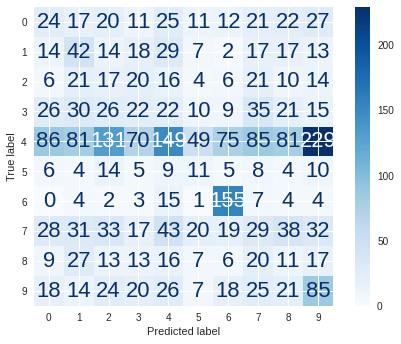

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(split0['y_test'], predicted_mnb_eda
                                        , cmap=plt.cm.Blues)
#plt.figure(figsize=(10, 10))
plt.show()

### 2.Support Vector Machine

In [ ]:
from sklearn import svm

clf_svm_eda = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
clf_svm_eda.fit(df_X_train_tfidf, split0['y_train'])

SVC(gamma='auto', kernel='linear')

Took 34 min.

In [ ]:
import sklearn.metrics as metrics

In [ ]:
predicted_svm_eda = clf_svm_eda.predict(X_test_tfidf)
print(metrics.classification_report(split0['y_test'], predicted_svm_eda) )

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


              precision    recall  f1-score   support

           0       0.10      0.14      0.12       190
           1       0.09      0.14      0.11       173
           2       0.06      0.13      0.09       135
           3       0.13      0.17      0.14       216
           4       0.61      0.30      0.40      1036
           5       0.04      0.07      0.05        76
           6       0.41      0.49      0.44       195
           7       0.11      0.12      0.11       290
           8       0.06      0.06      0.06       139
           9       0.15      0.16      0.15       258

    accuracy                           0.22      2708
   macro avg       0.18      0.18      0.17      2708
weighted avg       0.32      0.22      0.25      2708



In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(split0['y_test'], predicted_svm_eda)

0.17805714255016472